<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/2%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_0909_%EC%95%99%EC%83%81%EB%B8%94_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

과제 : 핸즈온 7장 앙상블 학습과 랜덤 포레스트

p.245-271

# [Chapter 7] 앙상블 학습과 랜덤 포레스트

앙상블 학습 : 여러 개의 예측기로부터 예측을 수집하여 모델 1개를 사용하는 것보다 좋은 예측을 얻는 방법

앙상블 : 일련의 예측기


- 랜덤 포레스트 : 결정 트리의 앙상블
- 배깅
- 부스팅
- 스태킹

## 7.1 투표 기반 분류

- 직접 투표(hard voting) 분류기 : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측, 다수결 투표

- 각 분류기가 약한 학습기더라도 충분히 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음
  - 약한 학습기 : 랜덤 추측보다 조금 더 높은 성능을 내는 분류기

- 앙상블 방법은 분류기가 가능한 한 서로 독립적일 때 성능이 좋아짐
- VotingClassifier : 여러 분류기를 조합한 투표 기반 분류기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.75
RandomForestClassifier 0.9
SVC 0.95
VotingClassifier 0.9


- 투표 기반 분류기가 개별 분류기보다 성능이 조금 더 높음

- 간접 투표(soft voting) : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측
  - 확률이 높은 투표에 더 비중을 두기 때문에 직접 투표보다 성능이 높음
  - voting = "soft"로 지정, 모든 분류기가 클래스의 확률을 추정할 수 있으면 사용 가능(즉, predict_proba 메서드가 있으면)
  - SVC는 클래스 확률 제공 X → probability 변수를 True로 지정

# 7.2 배깅과 페이스팅

- 다양한 분류기를 만드는 방법
  1. 분류기마다 다른 훈련 알고리즘 사용
  2. 훈련 세트의 서브셋을 무작위로 구성(알고리즘은 같음)


- 페이스팅(pasting) : 중복을 허용하지 않고 샘플링하는 방식


- 배깅(bagging) : 훈련 세트에서 중복을 허용하여 샘플링하는 방식(bootstrap aggregating)
  1. 훈련 세트에서 무작위로 샘플링, 여러 개의 예측기 훈련
  2. 훈련이 끝나면, 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측 생성 (수집 함수)
    - 분류 → '최빈값' 사용
    - 회귀 → '평균' 계산



- 개별 예측기는 원본 훈련 세트로 훈련한 것보다 훨씬 크게 편향됨

  → but 수집 함수 통과하면 편향/분산 모두 감소
- 일반적으로 원본 데이터셋을 사용해 하나의 예측기를 훈련할 때보다 분산이 줄어듦(편향은 비슷)

### 7.2.1 사이킷런의 배깅과 페이스팅

배깅과 페이스팅을 위한 클래스
- BaggingClassifier : 분류
    
    → 기반이 되는 분류기가 클래스 확률 추정 가능하면(predict_proba()가 있으면), 자동으로 간접 투표 방식 사용
- BaggingRegressor : 회귀

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- bootstrap = False : 페이스팅 사용
- n_jobs : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정 (-1이면 가용한 모든 코어 사용)
- max_samples : 0.0 ~ 1.0 사이로 지정 시, 샘플링되는 데이터 수는 (훈련 세트 크기) * (max_samples)

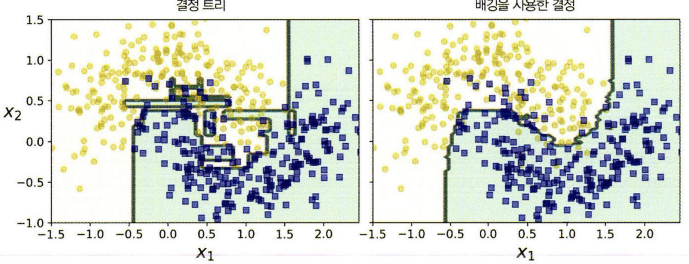

- 앙상블의 예측이 결정 트리 1개보다 일반화가 훨씬 잘 됨
- 앙상블은 비슷한 편향에서 더 작은 분산을 만듦  
  → 훈련 세트의 오차 수는 비슷하지만, 결정 경계는 덜 불규칙
- 배깅은 서브셋의 다양성 증가로 인해 페이스팅보다 편향이 조금 더 높지만, 예측기들간의 상관관계를 줄이므로 분산 감소
- 시간, CPU 파워가 여유 있다면 → 교차 검증으로 배깅, 페이스팅 모두 평가

### 7.2.2 obb 평가

- obb(out-of-bag) 샘플 : 샘플링을 할 때, 훈련 샘플에서 선택되지 않은 샘플(평균 37%)
  - 별도의 검증 세트를 사용하지 않고 obb 샘플을 사용해 평가 가능
  - 각 예측기의 oob 평가를 평균하여 평가
- oob_score=True : 훈련 후, 자동으로 oob 평가 수행
- oob_score_ : 평가 점수 결과 저장된 변수

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [ ]:
bag_clf.oob_decision_function_

array([[0.89847716, 0.10152284],
       [0.        , 1.        ],
       [0.9119171 , 0.0880829 ],
       [0.        , 1.        ],
       [0.02162162, 0.97837838],
       [0.        , 1.        ],
       [0.04117647, 0.95882353],
       [0.18134715, 0.81865285],
       [0.05084746, 0.94915254],
       [0.99450549, 0.00549451],
       [0.95428571, 0.04571429],
       [0.11351351, 0.88648649],
       [0.47738693, 0.52261307],
       [0.00518135, 0.99481865],
       [0.00581395, 0.99418605],
       [0.        , 1.        ],
       [0.95027624, 0.04972376],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.12135922, 0.87864078],
       [0.98192771, 0.01807229],
       [1.        , 0.        ],
       [0.77040816, 0.22959184],
       [0.        , 1.        ],
       [0.95744681, 0.04255319],
       [0.51295337, 0.48704663],
       [1.        , 0.        ],
       [0.89385475, 0.10614525],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.

- oob_decision_function_ : oob 샘플에 대한 결정 함수의 값 저장된 변수
  - 왼쪽 : 양성 클래스에 속할 확률
  - 오른쪽 : 음성 클래스에 속할 확률

## 7.3 랜덤 패치와 랜덤 서브스페이스

- 특성 샘플링 : 더 다양한 예측기를 만들며 편향 늘리는 대신 분산 낮춤
  - 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련
  - (이미지와 같은) 고차원 데이터셋에서 유용
  - 매개 변수 : max_features, bootstrap_features

- 랜덤 패치 방식 : 훈련 '특성'과 '샘플'을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식 : 특성 샘플링 (훈련 샘플은 모두 사용)
  - bootstrap=False, max_samples=1.0 → 샘플링 X
  - bootstrap_features=True, max_features는 1.0보다 작게 설정 → 특성 샘플링



## 7.4 랜덤 포레스트

- 랜덤 포레스트 : 배깅 방법을 적용한 결정 트리의 앙상블
  - max_samples : 훈련 세트의 크기
  - BaggingClassifier에 DecisionClassifier 넣는 대신
    
    → RandomForestClassifier 사용

- (랜덤 포레스트에서) 트리 노드 분할 시 : 전체 특성 중 최선의 특성 찾는 대신, 무작위로 선택한 특성 후보 중 최적의 특성 찾는 식으로 무작위성 더 주입

  → 더욱 다양한 트리, 분산 낮아져 더 훌륭한 모델이 됨 (편향은 늘어남)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- BaggingClassifier를 사용하여 랜덤 포레스트와 유사하게 만든 코드

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

- (랜덤 포레스트) 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
- 트리를 무작위하게 만들기 위해, 최적의 임곗값 찾는 대신 후보 특성을 사용해 무작위 분할 후 최상의 분할 선택


- 익스트림 랜덤 트리(줄여서 엑스트라 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트
  - 편향은 늘지만 분산 낮아짐
  - 모든 노드에서 특성마다 최적의 임곗값을 찾는 것이 시간이 많이 소요되므로, 랜덤 포레스트보다 빠름
  - ExtraTreesClassifier

### 7.4.2 특성 중요도
- 랜덤 포레스트 장점 : 상대적 중요도 측정 쉬움
  - 사이킷런은 어떤 특성을 사용한 노드가 불순도를 얼마나 감소시키는지 확인 → 특성 중요도 측정
  - 특성 중요도 = 가중치 평균 (각 노드의 가중치 = 연관된 훈련 샘플 수)
  - 특성마다 점수 계산 후 중요도의 전체 합이 1이 되도록 정규화
  - feature_importances_ : 특성 중요도 값 저장된 변수

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10108162168321627
sepal width (cm) 0.023265141190679788
petal length (cm) 0.4570140176653329
petal width (cm) 0.418639219460771


- 중요한 특성 : 꽃잎의 길이(45.7%), 너비(41.8%)


- 결정 트리 기반 모델은 모두 특성 중요도 제공
- 결정 트리의 특성 중요도
  
  : (현재 노드의 샘플 비율) - (왼쪽 자식 노드의 샘플 비율 X 불순도) - (오른쪽 자식 노드의 샘플 비율 X 불순도)

- 랜덤 포레스트의 특성 중요도

  : 각 결정 트리의 특성 중요도 모두 계산하여 더한 후, 트리 수로 나눔

## 7.5 부스팅

- 부스팅 : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블
  - 앞의 모델을 보완하며 일련의 예측기 학습
  - 에이다부스트(AdaBoost) : adaptive boosting의 줄임말
  - 그래디언트 부스팅(gradient boosting)

### 7.5.1 에이다부스트

- 이전 예측기 보완하는 방법 : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높임
  - 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰짐 → 에이다부스트
  - 이전 분류기에서 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임

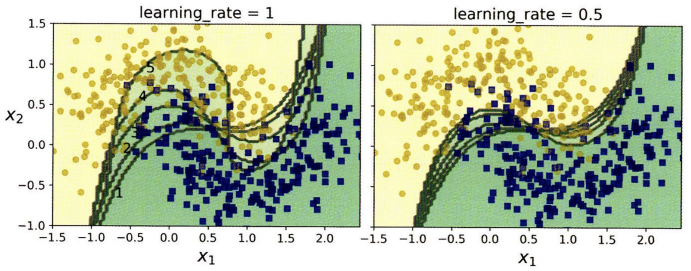

- moons 데이터셋에 훈련시킨 연속된 예측기 5개의 결정 경계
  
  → 뒤로 갈수록 샘플들을 더 정확히 예측

- 모든 예측기의 훈련이 끝나면, 배깅 or 페이스팅과 비슷한 방식으로 예측 생성
  
  → but 예측기마다 다른 가중치 적용
- 각 예측기는 이전 예측기가 훈련되고 평가되어야 학습될 수 있기 때문에 병렬화 불가

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

- SAMME : 에이다부스트의 다중 클래스 버전
  - 클래스가 2개일 때는 SAMME와 에이다부스트 동일
- SAMME.R : 예측기가 클래스의 확률 추정 가능하면 사용(predict_proba() 존재 시), 일반적으로 성능이 더 좋음

### 7.5.2 그레이디언트 부스팅

- 그래디언트 부스팅 : 이전 예측기가 만든 잔여 오차(residual error)에 대하여 새로운 예측기를 학습

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

- y2 : 첫번째 예측기에서 생긴 잔여 오차
- 첫번째 예측기에서 생긴 잔여 오차에 두번째 예측기(tree_reg2) 훈련


In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

- GradientBoostingRegressor : GBRT 앙상블
  - n_estimators : 트리 수
  - learning_rate : 각 트리의 기여 정도 조절

    → 낮게 설정 시 많은 트리가 필요하지만, 일반적으로 예측의 성능은 좋아짐

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=17)

- staged_predict() : 최적의 트리 수를 찾기 위한 조기 종료 기법

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break   # 조기 종료

- warm_start=True : fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가
- subsample : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율 지정
  - 0.25로 지정하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습
  - 편향 증가, 분산 감소
  - 훈련 속도를 상당히 높일 수 있음
  
  → 확률적 그래디언트 부스팅

[추가 내용 - 매개변수 '*loss*' ]
- GradientBoostingClassifier
  - 'deviance' : 기본값, 로지스틱 손실함수
  - 'exponential' : 에이다부스트에서 사용
  
- GradientBoostingRegressor
  - 'ls' : 기본값, 최소제곱
  - 'lad' : 최소 절댓값 오차
  - 'huber' : 후버 손실 함수
  - 'quantile' : 사분위수 손실 함수

[**XGBoost**]
- extreme gradient boosting
- 최적화된 그래디언트 부스팅

In [ ]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

## 7.6 스태킹

- 스태킹 : 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측 수행

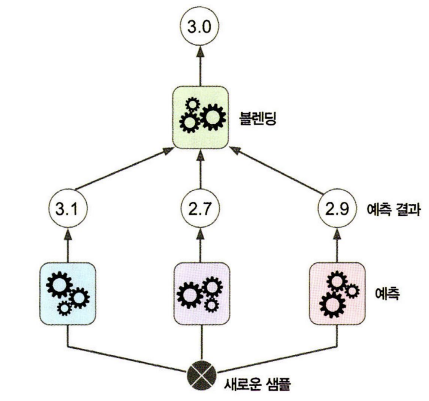

- 3개의 예측기가 예측한 각각 다른 값을 마지막 예측기(블렌더 or 메타 학습기)가 입력으로 받아 최종 예측 생성
- 블렌더 학습 → 홀드 아웃 세트 사용

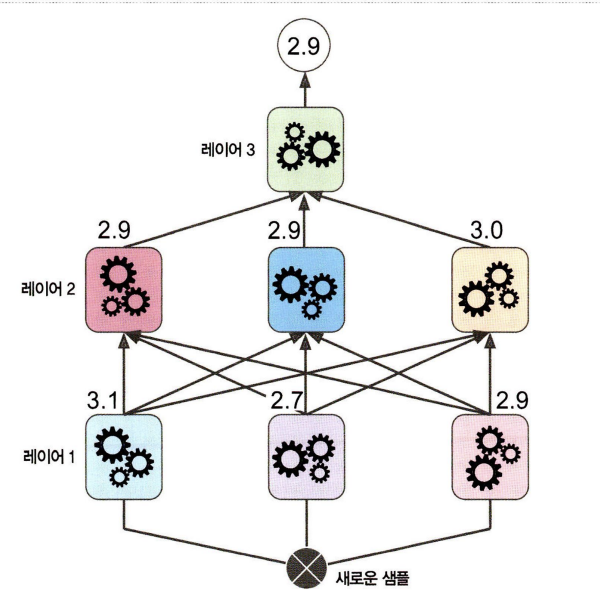

- 블렌더 여러 개 훈련 가능